In [1]:
library(caret)
library(tm)
library(caTools)
library(xgboost)
library(RWeka)
library(dplyr)
library(tidyr)
library(data.table)
library(jsonlite)
library(purrr)
library(RecordLinkage)
library(stringr)
library(tm)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.4.4"Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Warning message:
"package 'RWeka' was built under R version 3.4.4"
Attaching package: 'RWeka'

The following object is masked from 'package:caTools':

    LogitBoost


Attaching package: 'dplyr'

The following object is masked from 'package:xgboost':

    slice

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was built under R version 3.4.4"Warning message:
"package 'data.table' was built under R version 3.4.4"
Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last


Attaching package: 'purrr'

The following object is

Import the Dataset

In [2]:
train <-read.csv("C:/Users/manjeet.singh/Desktop/dataset/train.csv", stringsAsFactors = FALSE, na.strings = c(""," ","NA"))
glimpse(train)
setDT(train)
dim(train)

Observations: 1,157
Variables: 9
$ Source          <chr> "FORUMS", "FORUMS", "BLOG", "FORUMS", "FORUMS", "FO...
$ Host            <chr> "cafepharma.com", "www.patient.co.uk", "http://abcn...
$ Link            <chr> "http://cafepharma.com/boards/threads/epstein.59631...
$ Date.ET.        <chr> "6/15/2016", "5/7/2016", "4/14/2016", "6/18/2016", ...
$ Time.ET.        <chr> "13:58:00", "0.820833333", "15:00:38", "20:46:00", ...
$ time.GMT.       <chr> "6/15/2016 23:28", "42498.21667", "4/15/2016 0:30",...
$ Title           <chr> "Epstein", "Enlarged Heart.Thread Enlarged Heart", ...
$ TRANS_CONV_TEXT <chr> "I don't disagree with you in principle. I'm just s...
$ Patient_Tag     <int> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...


[1] 1157    9

In [3]:
test <- read.csv("C:/Users/manjeet.singh/Desktop/dataset/test.csv", stringsAsFactors = FALSE, na.strings = c(""," ","NA"))
glimpse(test)
setDT(test)
dim(test)

Observations: 571
Variables: 10
$ Index           <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
$ Source          <chr> "BLOG", "FORUMS", "BLOG", "FORUMS", "BLOG", "Facebo...
$ Host            <chr> "uhmagonline.com", "implantinformationnetwork.yuku....
$ Link            <chr> "http://uhmagonline.com/son-of-the-late-kimbo-slice...
$ Date.ET.        <chr> "7/30/2016", "6/20/2016", "6/15/2016", "7/17/2016",...
$ Time.ET.        <chr> "0:41:23", "0:07:30", "15:44:00", "19:41:00", "15:3...
$ time.GMT.       <chr> NA, "6/20/2016 9:37", "6/16/2016 1:14", NA, "4/5/20...
$ Title           <chr> NA, "My Story --", "US FDA ?????canagliflozin?dapag...
$ TRANS_CONV_TEXT <chr> "Baby Slice, the son of the late Kimbo Slice, has s...
$ X               <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...


[1] 571  10

Data Cleaning


In [5]:
test$Patient_Tag<-NA
tr <- train[,.(Patient_Tag,TRANS_CONV_TEXT,Title)]
ts <-test[,.(Patient_Tag,TRANS_CONV_TEXT,Title)]

tdata <- rbindlist(list(tr,ts))

In [6]:
tdata[,Trans_count := str_count(TRANS_CONV_TEXT,pattern = "\\w+")]
tdata[,Trans_len := str_count(TRANS_CONV_TEXT)]

In [7]:
tdata[, Title_count:= str_count(Title,pattern = "\\w+")]
tdata[,Title_len := str_count(Title)]


LevenshteinDist returns the Levenshtein distance.Compute the approximate string distance between character vectors

In [8]:
tdata[,lev_Text_Title := levenshteinDist(TRANS_CONV_TEXT,Title)]


Text Mining


In [9]:
text_corpus <- Corpus(VectorSource(tdata$TRANS_CONV_TEXT))
inspect(text_corpus[1])

text_corpus <- tm_map(text_corpus, tolower)
text_corpus <- tm_map(text_corpus, removePunctuation)
text_corpus <- tm_map(text_corpus, removeNumbers)
text_corpus <- tm_map(text_corpus, stripWhitespace)
text_corpus <- tm_map(text_corpus, removeWords, c(stopwords('english')))
text_corpus <- tm_map(text_corpus, stemDocument,language = "english")


<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

[1] I don't disagree with you in principle. I'm just saying that Entresto has been a major failure of Novartis commercial organisation. They (Novartis) were totally exposed at Q1 call. With reimbursement issues being resolved, the true underlying problem with Entresto was unveiled: Novartis failed to create the demand for the drug. Their disease-awareness campaign in the US (the drowning man) was incredibly poor (fear- and panic-inducing). What is more, they advertised the wrong condition. They were raising awareness of life-threatening ACUTE heart failure instead of CHRONIC heart failure, for which Entresto is indicated. Entresto has nothing to do with the treatment of acute heart failure. If that was not due to their shocking lack of knowledge of the disease area, it can only be explained as a conscious misleading of patients. They managed to alienate medical community, advocacy groups

Trigram Function

In [11]:
Trigram_Tokenizer <- function(x){
  NGramTokenizer(x, Weka_control(min=3, max=3))
}

Create a matrix

In [12]:
docterm_corpus <- DocumentTermMatrix(text_corpus, control = list(tokenize = Trigram_Tokenizer))
dim(docterm_corpus)

[1]  1728 22504

In [14]:
new_docterm_corpus <- removeSparseTerms(docterm_corpus,sparse = 0.99)
dim(new_docterm_corpus)


[1] 1728 1873

In [15]:
colS <- colSums(as.matrix(new_docterm_corpus))
length(colS)

[1] 1873

In [16]:
doc_features <- data.table(name = attributes(colS)$names, count = colS)

In [17]:
doc_features[order(-count)][1:10] #top 10 most frequent words
doc_features[order(count)][1:10] #least 10 freuqnet

name,count
heart,4960
failur,2357
patient,1925
can,1850
diseas,1507
blood,1490
studi,1333
will,1275
use,1196
also,1155


name,count
oblig,18
skill,19
intestin,19
divid,19
opt,19
expertis,19
somewher,19
withdraw,19
magic,19
input,19


Create a wordcloud

Loading required package: RColorBrewer


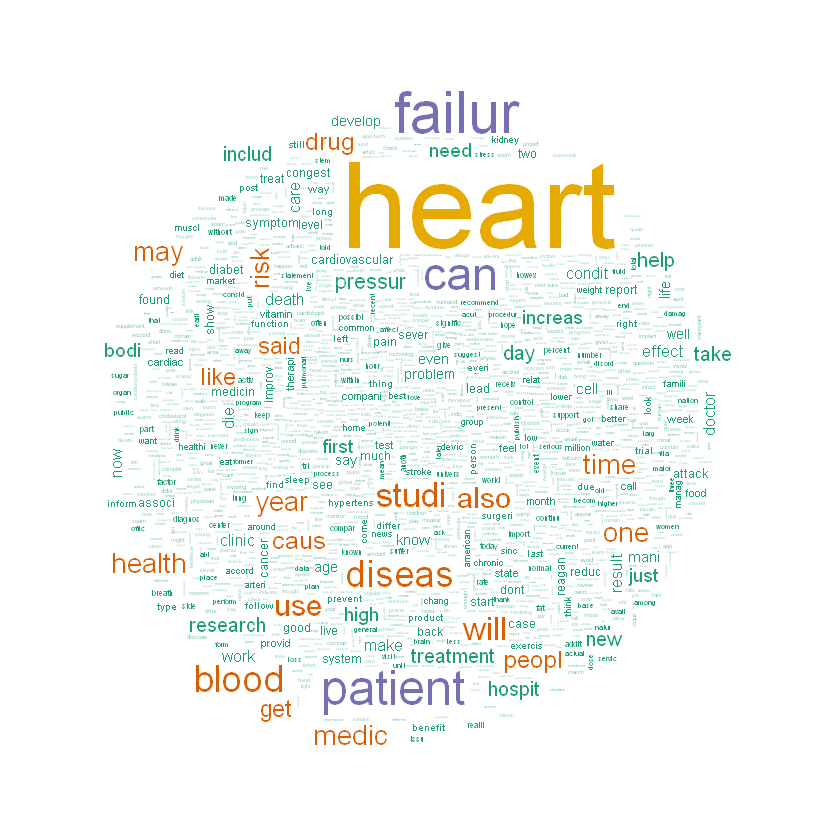

In [18]:
library(wordcloud)
#this wordcloud is exported
wordcloud(names(colS), colS, min.freq = 5000, scale = c(6,.1), colors = brewer.pal(6, 'Dark2'))

In [19]:
processed_data <- as.data.table(as.matrix(new_docterm_corpus))
data_one <- cbind(data.table(Patient_Tag = tdata$Patient_Tag),processed_data)

Split the data set into train and test


In [20]:
train_one<-filter(data_one, Patient_Tag !="NA")
test_one <- data_one[1158:nrow(tdata),]

Warning message:
"`as_dictionary()` is soft-deprecated as of rlang 0.3.0.
Please use `as_data_pronoun()` instead
This warning is displayed once per session."Warning message:
"`new_overscope()` is soft-deprecated as of rlang 0.2.0.
Please use `new_data_mask()` instead
This warning is displayed once per session."Warning message:
"The `parent` argument of `new_data_mask()` is deprecated.
The parent of the data mask is determined from either:

  * The `env` argument of `eval_tidy()`
  * Quosure environments when applicable
This warning is displayed once per session."Warning message:
"`overscope_clean()` is soft-deprecated as of rlang 0.2.0.
This warning is displayed once per session."

In [21]:
train$Patient_Tag<-as.factor(train_one$Patient_Tag)

In [22]:
#returns 70% indexes from train data
sp <- sample.split(Y = train_one$Patient_Tag ,SplitRatio = 0.7)

In [23]:
setDT(train_one)
setDT(test_one)

Create data for xgboost

In [24]:
xg_val <- train_one[sp]
target <- train_one$Patient_Tag
xg_val_target <- target[sp]

In [25]:
d_train <- xgb.DMatrix(data = as.matrix(train_one[,-c("Patient_Tag")]),label = target)
d_val <- xgb.DMatrix(data = as.matrix(xg_val[,-c("Patient_Tag")]), label = xg_val_target)
d_test <- xgb.DMatrix(data = as.matrix(test_one[,-c("Patient_Tag")]))

In [26]:
param <- list(booster="gbtree",
              objective="reg:logistic",
              gamma=5,
              eval_metric="auc",
              eta = 0.02)

In [27]:
set.seed(2017)
watch <- list(val=d_val, train=d_train)

In [28]:
xgb <- xgb.train(data = d_train,
                  params = param,
                  watchlist=watch,
                  nrounds = 400,
                  print_every_n = 10)

[1]	val-auc:0.792242	train-auc:0.791794 
[11]	val-auc:0.911595	train-auc:0.909353 
[21]	val-auc:0.939577	train-auc:0.932749 
[31]	val-auc:0.951598	train-auc:0.945277 
[41]	val-auc:0.958310	train-auc:0.954737 
[51]	val-auc:0.961212	train-auc:0.960158 
[61]	val-auc:0.964161	train-auc:0.963847 
[71]	val-auc:0.966993	train-auc:0.967441 
[81]	val-auc:0.969181	train-auc:0.969904 
[91]	val-auc:0.971063	train-auc:0.971831 
[101]	val-auc:0.972130	train-auc:0.972930 
[111]	val-auc:0.973900	train-auc:0.974839 
[121]	val-auc:0.975917	train-auc:0.976683 
[131]	val-auc:0.977016	train-auc:0.977815 
[141]	val-auc:0.977757	train-auc:0.978551 
[151]	val-auc:0.978870	train-auc:0.979619 
[161]	val-auc:0.979686	train-auc:0.980434 
[171]	val-auc:0.980279	train-auc:0.981123 
[181]	val-auc:0.980734	train-auc:0.981536 
[191]	val-auc:0.980910	train-auc:0.981863 
[201]	val-auc:0.981002	train-auc:0.981882 
[211]	val-auc:0.981012	train-auc:0.981909 
[221]	val-auc:0.981151	train-auc:0.982154 
[231]	val-auc:0.981151

In [29]:
pred_test<-matrix(predict(xgb, d_test))
pred_train<-matrix(predict(xgb, d_train))

In [30]:
fitted.results<-pred_test
fitted.results2<-pred_train

In [31]:
fitted.results <- ifelse(fitted.results >= 0.5,1,0)
fitted.results2 <- ifelse(fitted.results2 >= 0.5,1,0)

Confusion Matrix

In [32]:
confusionMatrix(fitted.results2,train_one$Patient_Tag)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 913  69
         1   4 171
                                          
               Accuracy : 0.9369          
                 95% CI : (0.9213, 0.9502)
    No Information Rate : 0.7926          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7868          
 Mcnemar's Test P-Value : 6.854e-14       
                                          
            Sensitivity : 0.9956          
            Specificity : 0.7125          
         Pos Pred Value : 0.9297          
         Neg Pred Value : 0.9771          
             Prevalence : 0.7926          
         Detection Rate : 0.7891          
   Detection Prevalence : 0.8487          
      Balanced Accuracy : 0.8541          
                                          
       'Positive' Class : 0               
                                          

View variable importance plot

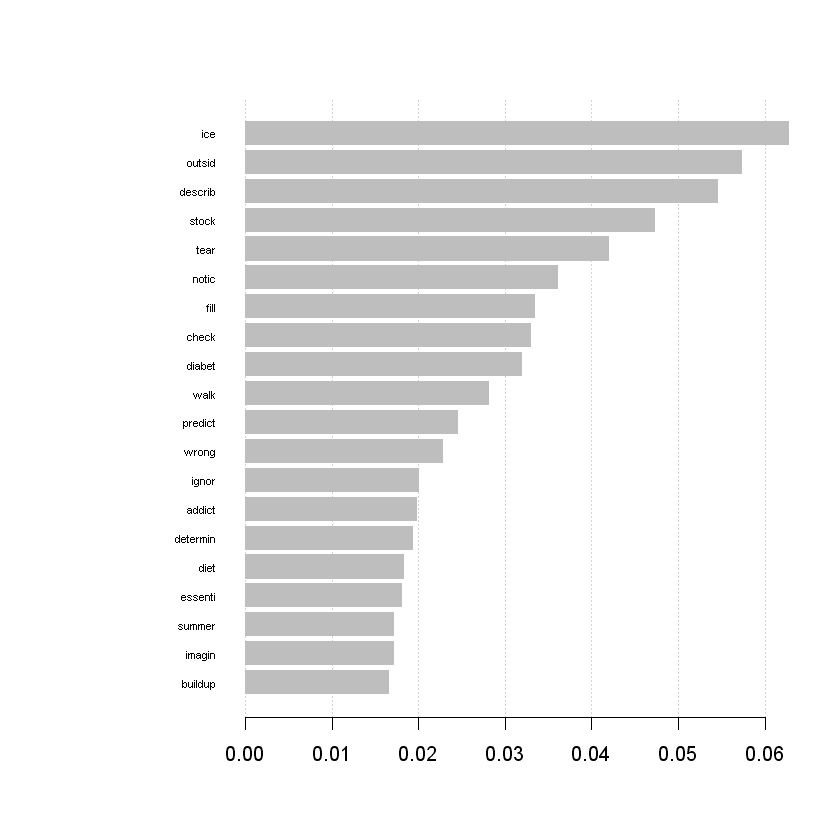

In [33]:
mat <- xgb.importance (feature_names = colnames(train_one),model = xgb)
xgb.plot.importance (importance_matrix = mat[1:20]) 

In [34]:
test$Patient_Tag<-NULL
final<-cbind(test, fitted.results)
setnames(final,"V1", "Patient_Tag")

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:wordcloud':

    textplot

The following object is masked from 'package:stats':

    lowess



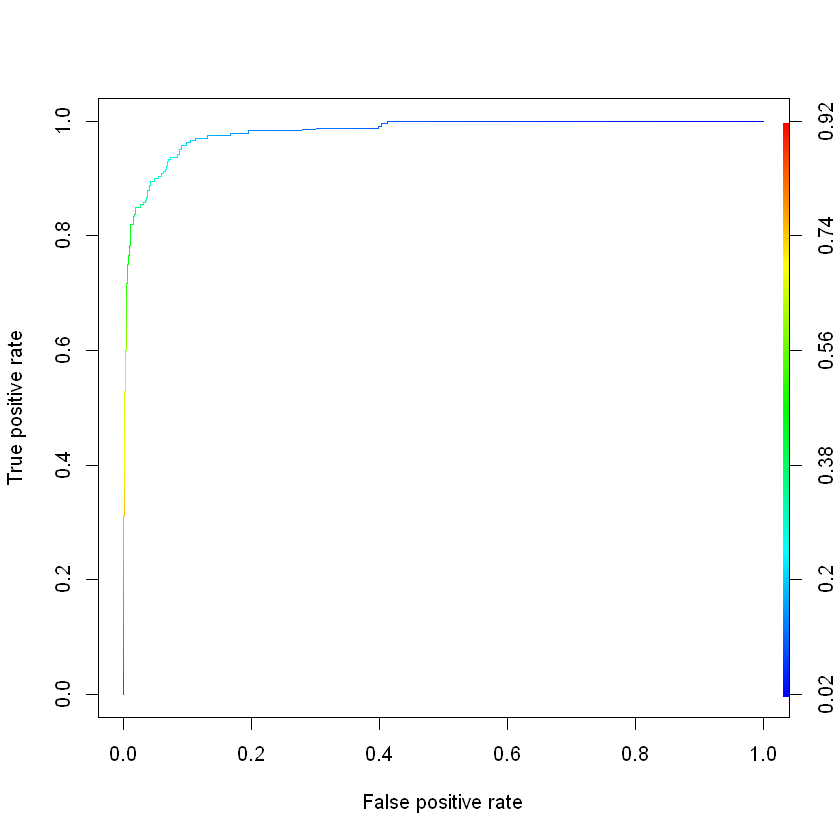

In [35]:
library(ROCR)
ROCRpred <- prediction(pred_train, train_one$Patient_Tag)
ROCRperf <- performance(ROCRpred, 'tpr','fpr')
plot(ROCRperf, colorize = TRUE, text.adj = c(-0.2,1.7))

In [36]:
auc <- performance(ROCRpred, measure = "auc")
auc <- auc@y.values[[1]]

In [37]:
auc

[1] 0.9821542